In [1]:
import numpy as np
import pandas as pd
from root_pandas import read_root
import glob
import os
import matplotlib.pyplot as plt

from helpfunction import CheckBorderTPC,CheckBorderFixed,effErr,sciNot,sciNot2

%matplotlib inline

In [2]:
pd.options.display.max_columns = 999
gr      = 1.618
nan     = -2147483648
min_root_size = 20000 # Skip root files smaller than x bytes

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV

# LAr EM showers
R_moliere =  9.5 # cm
X_o       = 13.9 # cm
E_c       = 0.035# GeV

# Fiducial volume borders in x,y,z:
fid_arr= [[10,10],[20,20],[10,50]]

# Minimum reconstructable energies:
min_e = 0.02+mass_e # 20MeV
min_p = 0.04+mass_p # 40MeV

In [3]:
checkana=False
gpvmsdir = '/run/user/1002/gvfs/sftp:host=uboonegpvm02.fnal.gov,user=wvdp'
if not checkana:
    # Option 1: no checkana, verify validity yourself and use input directory
    inputlist = []
    #inputlist += glob.glob("/home/wouter/Templates/April/cosmic_intime_1s0t_dev_newremoval/*.root")
    inputlist += glob.glob("/home/wouter/Downloads/*.root")
    filelist  = []
    for fname in inputlist:
        if (os.stat(fname).st_size)<min_root_size:
                print("File",fname,"was corrupt. Size:",os.stat(fname).st_size/1000, "kb, skipping to next file.")
        else:
            filelist.append(fname)

if checkana:
    # Option 2: After checkana, just pass the filesana list.
    filelist = [gpvmsdir+line.rstrip() for line in open(gpvmsdir+'/uboone/data/users/wvdp/book/v06_26_01_12/d/filesana.list')]

print(len(filelist),"valid ROOT files collected.")

1 valid ROOT files collected.


In [4]:
# Signal Definition 1e0p 
def true_thresholds_1e0p(row):
    if CheckBorderTPC(*row[["true_vx","true_vy","true_vz"]],array=fid_arr):
        passed_e=False
        for pdg,E in zip(*row[["nu_daughters_pdg","nu_daughters_E"]]):
            if pdg==11 and E>min_e:
                return True
    return False

def KatrinBDT(row):
    if row["n_tracks"]==0:
        return True
    
    if np.all(row["predict_mu"]<0.9):
        if np.all(row["predict_cos"]<0.9):
            return True
    return False

In [5]:
fieldx = "flash_PE_max"

fidvol=0
fidvol_weights_1s=[]
fidvol_true_E_1s=[]
fidvol_weights_0s=[]
fidvol_true_E_0s=[]

passed=0
flashpassed=0

signal=0
signal_weights=[]
signal_true_E=[]

cat2_weights_1s=[]
cat2_true_E_1s=[]
cat2_weights_0s=[]
cat2_true_E_0s=[]

total=0
category=np.zeros(8)

for i_f,fname in enumerate(filelist[:250]):
    #print(fname)
    dftemp=read_root(fname,"wouterNueCC/pandoratree",columns=['run',"subrun","event",
                                                              "true_1eX_signal","bnbweight", fieldx,
                                                              #"true_vx","true_vy","true_vz","nu_daughters_pdg","nu_daughters_E",
                                                              "fiducial","track_bdt_precut",
                                                              #"predict_em","predict_mu","predict_cos","predict_p","n_tracks","numu_passed",
                                                          'passed','category','flash_time',"n_showers",'flash_passed'])
    
    dftemp["bnbweight"]=1
    total+=dftemp["bnbweight"].sum()
    
    
    #dftemp=dftemp[dftemp["true_1eX_signal"]==1]
    signal+=dftemp["bnbweight"].sum()
    signal_weights.extend(dftemp["bnbweight"].values)
    signal_true_E.extend(dftemp[fieldx].values)
    
    flashtemp = dftemp[dftemp["flash_passed"].apply(lambda x: np.any(x!=-1))]
    if len(flashtemp.index)>0:
        flashpassed+= flashtemp["bnbweight"].sum()
    
    dftemp=dftemp[ (dftemp["passed"]==1) & (dftemp["track_bdt_precut"]==1)]
    passed+=dftemp["bnbweight"].sum()
    
    dftemp=dftemp[dftemp["fiducial"]==1]
    fidvol+=dftemp["bnbweight"].sum()
    fidvol_weights_0s.extend(dftemp["bnbweight"].values)
    fidvol_true_E_0s.extend(dftemp[fieldx].values)
    fidvol_weights_1s.extend(dftemp[(dftemp["n_showers"]>0)]["bnbweight"].values)
    fidvol_true_E_1s.extend(dftemp[(dftemp["n_showers"]>0)][fieldx].values)
    
    this_category = np.bincount(dftemp['category'].values, weights= dftemp['bnbweight'].values )
    this_category = np.pad(this_category, (0, 8 - len(this_category)), 'constant')
    #print(this_category)
    category+=this_category
    
    cat2_weights_1s.extend(dftemp[(dftemp["n_showers"]>0) & (dftemp["category"]==2)]["bnbweight"].values)
    cat2_true_E_1s.extend(dftemp[(dftemp["n_showers"]>0) & (dftemp["category"]==2)][fieldx].values)
    cat2_weights_0s.extend(dftemp[(dftemp["category"]==2)]["bnbweight"].values)
    cat2_true_E_0s.extend(dftemp[(dftemp["category"]==2)][fieldx].values)
    
print(total)
print(signal)
print(flashpassed)
print(passed)
print(fidvol)

print(flashpassed/signal,"+/-",np.sqrt(flashpassed)/passed)
print(passed/signal,"+/-",np.sqrt(passed)/passed)
print(fidvol/signal,"+/-",np.sqrt(fidvol)/passed)
print(category[2]/signal,"+/-",np.sqrt(category[2])/passed)

print(category/sum(category))

ValueError: Pattern 'flash_PE_max' didn't match any branch

In [78]:
print(total)
print(signal)
print(flashpassed)
print(passed)
print(fidvol)

print(flashpassed/signal,"+/-",np.sqrt(flashpassed)/passed)
print(passed/signal,"+/-",np.sqrt(passed)/passed)
print(fidvol/signal,"+/-",np.sqrt(fidvol)/passed)
print(category[2]/signal,"+/-",np.sqrt(category[2])/passed)

print(category/sum(category))

124921.581504
29160.0638842
24302.9068889
23683.3356399
22404.0581198
0.833431194988 +/- 0.00658242988334
0.812183942187 +/- 0.00649798291426
0.768313067106 +/- 0.00632004943729
0.602000058981 +/- 0.00559434998598
[  0.00000000e+00   2.52724627e-02   7.83534844e-01   0.00000000e+00
   2.50896477e-05   0.00000000e+00   0.00000000e+00   1.91167604e-01]


In [120]:
true_E_denom = signal_true_E
weight_denom = signal_weights
print(len(true_E_denom))

true_E_nom_1 = fidvol_true_E_0s
weight_nom_1 = fidvol_weights_0s
true_E_nom_2 = fidvol_true_E_1s
weight_nom_2 = fidvol_weights_1s

true_E_pur_1 = cat2_true_E_0s
weight_pur_1 = cat2_weights_0s
true_E_pur_2 = cat2_true_E_1s
weight_pur_2 = cat2_weights_1s

100789


/home/wouter/Binaries/miniconda3/envs/rootenv/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


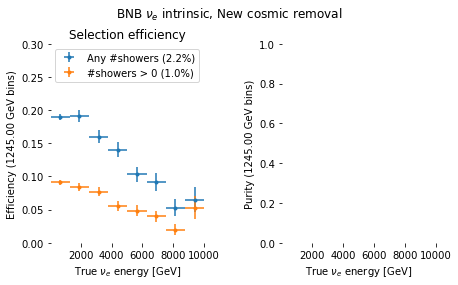

In [121]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,4),sharey=False,sharex=True)
plt.suptitle(r'BNB $\nu_e$ intrinsic, New cosmic removal')
N = 8
min_x = 40
max_x = 10000
binwidth=(max_x-min_x)/N
halfbin = binwidth/2
step=0.6

denom, edges = np.histogram(true_E_denom,bins=N,range=(min_x,max_x),weights=weight_denom)
nom1, _       = np.histogram(true_E_nom_1,bins=N,range=(min_x,max_x),weights=weight_nom_1)
nom2, _       = np.histogram(true_E_nom_2,bins=N,range=(min_x,max_x),weights=weight_nom_2)
purnom1, _    = np.histogram(true_E_pur_1,bins=N,range=(min_x,max_x),weights=weight_pur_1)
purnom2, _    = np.histogram(true_E_pur_2,bins=N,range=(min_x,max_x),weights=weight_pur_2)

eff1 = nom1/denom
eff2 = nom2/denom
#pur1 = purnom1/nom1
#pur2 = purnom2/nom2

ax[0].set_title('Selection efficiency')
ax[0].errorbar(edges[:-1]+halfbin, eff1 , xerr=halfbin, yerr=effErr(nom1,denom),alpha=1.0,fmt='.',label=r'Any #showers ('+sciNot(sum(weight_nom_1)/sum(weight_denom)*100)+'%)')
ax[0].errorbar(edges[:-1]+halfbin, eff2 , xerr=halfbin, yerr=effErr(nom2,denom),alpha=1.0,fmt='.',label=r'#showers > 0 ('+sciNot(sum(weight_nom_2)/sum(weight_denom)*100)+'%)')

#ax[1].set_title('Purity of selected events')
#ax[1].errorbar(edges[:-1]+halfbin, pur1 , xerr=halfbin, yerr=effErr(purnom1,nom1),alpha=1.0,fmt='.',label=r'Any #showers ('+sciNot(sum(weight_pur_1)/sum(weight_nom_1)*100)+'%)')
#ax[1].errorbar(edges[:-1]+halfbin, pur2 , xerr=halfbin, yerr=effErr(purnom2,nom2),alpha=1.0,fmt='.',label=r'#showers > 0 ('+sciNot(sum(weight_pur_2)/sum(weight_nom_2)*100)+'%)')


ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

ax[0].set_ylabel('Efficiency ('+sciNot2(binwidth)+' GeV bins)')
ax[1].set_ylabel('Purity ('+sciNot2(binwidth)+' GeV bins)')

ax[0].set_xlim(min_x,max_x)
ax[1].set_xlim(min_x,max_x)

ax[0].set_ylim(0,0.3)
ax[1].set_ylim(0,1.)

ax[0].set_xlabel(r'True $\nu_e$ energy [GeV]')
ax[1].set_xlabel(r'True $\nu_e$ energy [GeV]')

ax[0].legend(loc="upper center")
ax[1].legend(loc="lower center")

plt.tight_layout(w_pad=2.5)
fig.subplots_adjust(top=0.85)
plt.savefig("../Output/eff_pur_nue_new.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)